In [ ]:
import math
import sklearn.metrics as skmet
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress 
from datetime import datetime
from pandas import Series
%matplotlib inline 
import warnings
from google.colab import drive
drive.mount("/content/drive")

# ignoring warnings 
warnings.filterwarnings("ignore")

# reading data from csv
# Also parsing dates as Datetime so that we can extract features like year and months later on.
# making date colum out index since we are doing Time Series analysis 
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/USD_INR Historical Data.csv", index_col='Date', parse_dates=True)

# checking current python version
print("Using python version " + sys.version)

data.head()

Mounted at /content/drive
Using python version 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


,Price,Open,High,Low,Change %
Date,,,,,
2020-12-30,73.127,73.370,73.398,73.135,-0.36%
2020-12-29,73.390,73.545,73.545,73.313,-0.21%
2020-12-28,73.546,73.558,73.613,73.457,0.01%
2020-12-24,73.540,73.800,73.840,73.506,-0.31%
2020-12-23,73.770,73.905,73.905,73.654,-0.11%


### **Data Preprocessing**

In [ ]:
# adding missing dates and filling with last known value
index = pd.date_range('01-02-2002','12-31-2020')
data = data.reindex(index, method='backfill')
data['Price']

# Dropping colums that we don't need
data = data.drop(['Open', 'High', 'Low', 'Change %'], axis= 1)

# making a copy 
data_copy = data.copy()

# Extracting year, month and day from the date 
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day

data.tail()

,Price,year,month,day
2020-12-27,73.540,2020,12,27
2020-12-28,73.546,2020,12,28
2020-12-29,73.390,2020,12,29
2020-12-30,73.127,2020,12,30
2020-12-31,73.127,2020,12,31


### **Dataset Splitting**

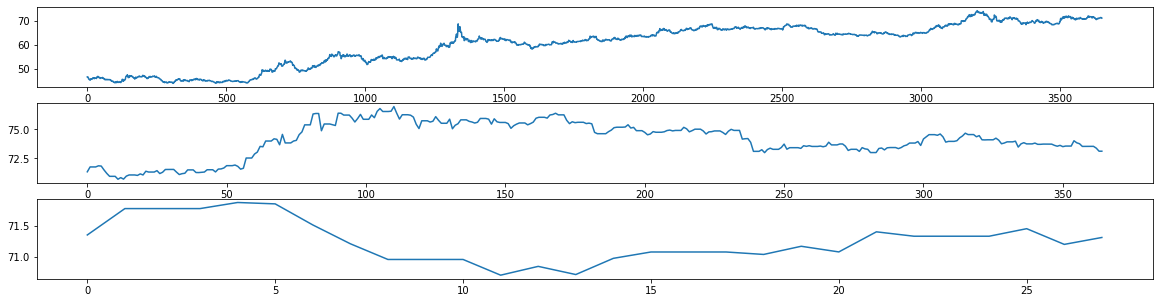

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[20,5])

train = data['01-01-2010':'01-01-2020']
train_array = train["Price"].to_numpy()

test = data['01-01-2020':'01-01-2021']
test = test[1:]
test_array = test["Price"].to_numpy()
test_month = test_array[:28]

ax[0].plot(train_array)
ax[1].plot(test_array)
ax[2].plot(test_month)

# **Improved Weighted FTS**

In [ ]:
#divide Universe of Discourse into eual intervals
def generatePartition(minx,maxx,part):
  res = {}
  isize = (maxx - minx)/part
  strt = minx + 0.0
  for i in range(part):
    res[str("A"+str(i))] = [strt,strt+isize,strt+(isize/2)]
    strt += isize
  return res

In [ ]:
#return fuzzy set corresponding to the data points
def fuzzify(data,partitions):
  for item in partitions:
    if (partitions[item][0] <= data) and (data <= partitions[item][1]):
      return item

def fuzzifyAll(data,partitions):
  fuzzySet = []
  for x in data:
    fuzzySet.append(fuzzify(x,partitions))
  # print(fuzzySet)
  return fuzzySet

In [ ]:
# generate temporal pattern or FLR : F(t) -> F(t+1)
def generateFLR(data):
  # print(len(data))
  res = [(data[i], data[i+1]) for i in range(len(data)-1)]
  #print(res)
  return res

In [ ]:
#group together FLRs with same precedent or LHS
def generateFLG(data):
  res = {}
  for item in data:
      if not (item[0] in res):
          res[item[0]] = {}
      if (item[1] in res[item[0]]):
          res[item[0]][item[1]] += 1
      else:
          res[item[0]][item[1]] = 1
  return res          

In [ ]:
#assign weight to all the FLG based on the number of recurrences
def calculateWeight(data):
  for item in data:
    sum = 0
    for obj in data[item]:
      sum += data[item][obj]
    for obj in data[item]:
      data[item][obj] /= sum
  return data

In [ ]:
#predict in accordance to the forecasting rules
def forecast(data,flg,n,partitions):
  # lastValue = data["Price"][-1]
  res = []
  res.append(data[-1])
  for i in range(n):
    fuzz = fuzzify(res[-1],partitions)
    newValue = res[-1]
    if fuzz in flg :
      temp = flg[fuzz]
      newValue = 0
      for item in temp:
        newValue += (temp[item]*partitions[item][2])
    res.append(res[-1])
    # print(newValue)
  return res[1:]

In [ ]:
#calculation of Mean Absolute Percentage Error
def calculateMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### **Forecasting using Improved Weighted Fuzzy Time Series Model**

In [ ]:
part = generatePartition(42,77,55)
fuzzySet = fuzzifyAll(train_array,part)
# fuzzySet[0],fuzzySet[1]
# print(train.head())
# print(train['01-01-2010':'01-10-2010'])
flr = generateFLR(fuzzySet)
# print(flr)
flg = generateFLG(flr)
# print(flg)
calculateWeight(flg)
# print(flg)
# print(M)
forecast_array = forecast(train_array,flg,365,part)
forecast_month_array = forecast(train_array,flg,28,part)
# len(forecast_array)

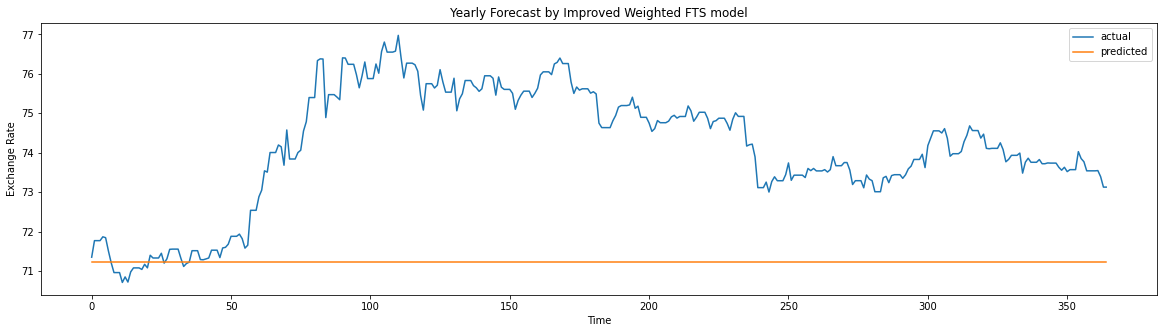

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])
ax.plot(test_array,label = "actual")
ax.plot(forecast_array,label="predicted")
ax.set_title("Yearly Forecast by Improved Weighted FTS model")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test_array,forecast_array))
print("RMSE = " + str(rmse))
mape = calculateMAPE(test_array,forecast_array)
print("MAPE = " + str(mape))

RMSE = 3.2767572351460736
MAPE = 3.9010046961192444


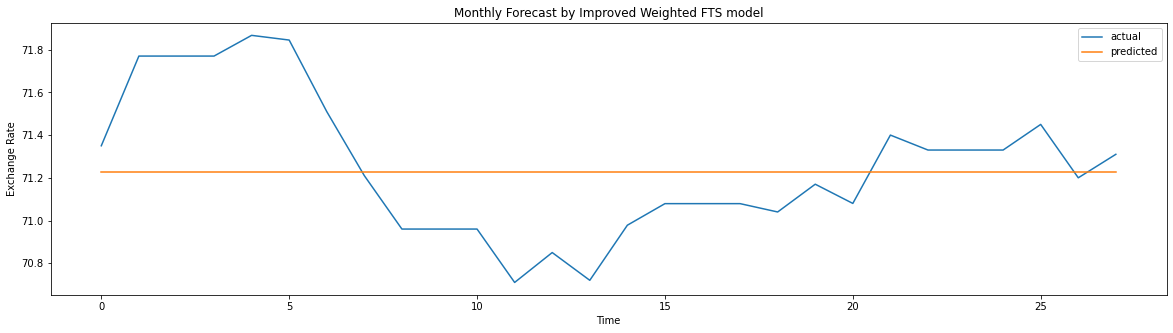

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])
ax.plot(test_month,label = "actual")
ax.plot(forecast_month_array,label="predicted")
ax.set_title("Monthly Forecast by Improved Weighted FTS model")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test_month,forecast_month_array))
print("RMSE = " + str(rmse))
mape = calculateMAPE(test_month,forecast_month_array)
print("MAPE = " + str(mape))

RMSE = 0.32497697720651825
MAPE = 0.3711404986144174


### **Rolling Forecsating**

In [ ]:
def rollingForecast(train_roll,part_roll,test_array,noOfWeeks):
  forecast_roll = []
  forecast_roll.append(train_roll[-1])
  for i in range(noOfWeeks):
    fs_roll = fuzzifyAll(train_roll,part_roll)
    flr_roll = generateFLR(fs_roll)
    flg_roll = generateFLG(flr_roll)
    calculateWeight(flg_roll)
    forecast_roll += forecast(train_roll,flg_roll,7,part_roll)
    train_roll = np.concatenate((train_roll,test_array[7*i:7*(i+1)]))
  return forecast_roll

# print(len(forecast_roll))

In [ ]:
part_roll = generatePartition(42,77,55)
forecast_roll_month = rollingForecast(train_array,part_roll, test_month,4)[:28]
forecast_roll = rollingForecast(train_array,part_roll, test_array,52)

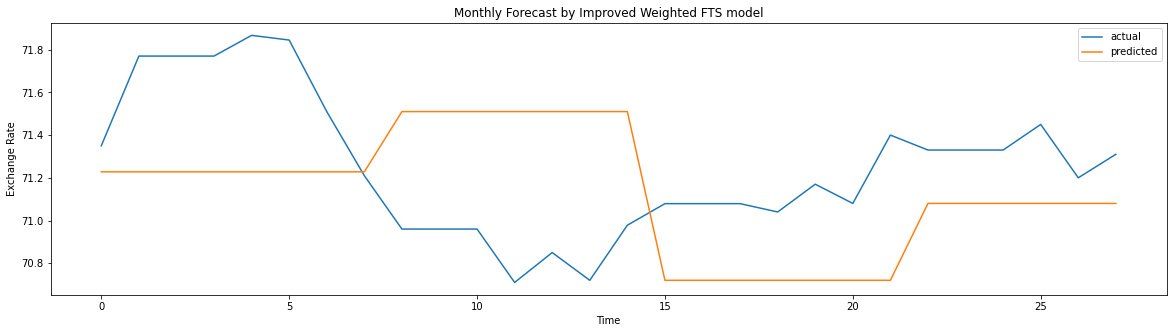

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])
ax.plot(test_month,label = "actual")
ax.plot(forecast_roll_month,label="predicted")
ax.set_title("Monthly Forecast by Improved Weighted FTS model")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test_month,forecast_roll_month))
print("RMSE for monthly prediction = " + str(rmse))
mape = calculateMAPE(test_month,forecast_roll_month)
print("MAPE for monthly prediction = " + str(mape))

RMSE for monthly prediction = 0.47548850819822375
MAPE for monthly prediction = 0.6062889356871297


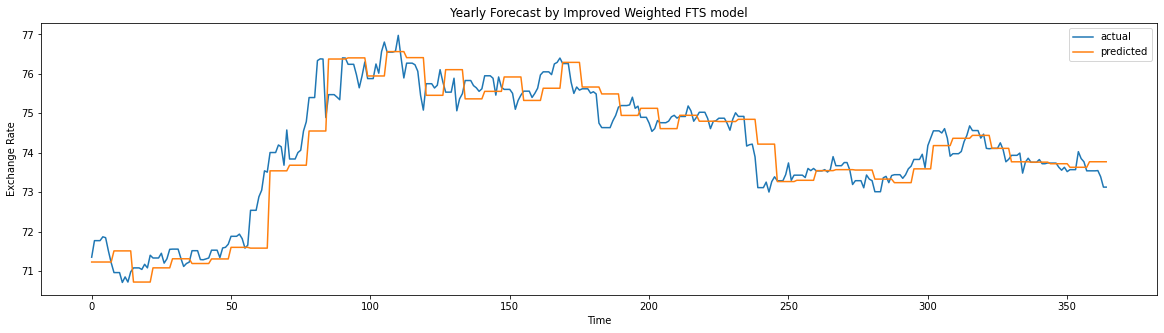

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])
ax.plot(test_array,label = "actual")
ax.plot(forecast_roll,label="predicted")
ax.set_title("Yearly Forecast by Improved Weighted FTS model")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test_array,forecast_roll))
print("RMSE for yearly prediction = " + str(rmse))
mape = calculateMAPE(test_array,forecast_roll)
print("MAPE for yearly prediction = " + str(mape))

RMSE for yearly prediction = 0.4837701650605796
MAPE for yearly prediction = 0.4699010537691604


# **pyFTS**

In [ ]:
!pip3 install -U git+https://github.com/petroniocandido/pyFTS
!pip3 install dill
!pip install SimpSOM

  Cloning https://github.com/petroniocandido/pyFTS to /tmp/pip-req-build-rdkndl7x
  Running command git clone -q https://github.com/petroniocandido/pyFTS /tmp/pip-req-build-rdkndl7x
  Created wheel for pyFTS: filename=pyFTS-1.6-cp37-none-any.whl size=217108 sha256=e3440b12a80ea0d950946852ffde7722bdfdb945c4b652a432991c2fdf3adf5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z424szf_/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS
  Created wheel for SimpSOM: filename=SimpSOM-1.3.4-cp37-none-any.whl size=17086 sha256=4570eac13f7d6b439bb0fdc27a43acf67372ed3d5448fdc5b821ade8edefe5dc
  Stored in directory: /root/.cache/pip/wheels/51/76/ee/c02f0bc20af4cd8f46ee4142ebf7bb654b737d6d8f2360d26b
Successfully built SimpSOM


In [ ]:
import seaborn as sns

from pyFTS.common import Util as cUtil
from pyFTS.benchmarks import benchmarks as bchmk, Util as bUtil
from pyFTS.partitioners import Util as pUtil
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.common import Membership as mf
from pyFTS.common import Transformations

from pyFTS.models import ismailefendi
from pyFTS.models import ifts

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
tdiff = Transformations.Differential(1)

dataset_name="USD-INR-forex"

temp = data['01-01-2010':'01-01-2020']
train = temp["Price"].to_numpy()
train_diff = tdiff.apply(train)

temp = data['01-01-2020':'01-01-2021']
test = temp["Price"].to_numpy()
test_diff = tdiff.apply(test)
test_month = test[:30]
test_diff_month = test_diff[:30]

### **Partitioning**

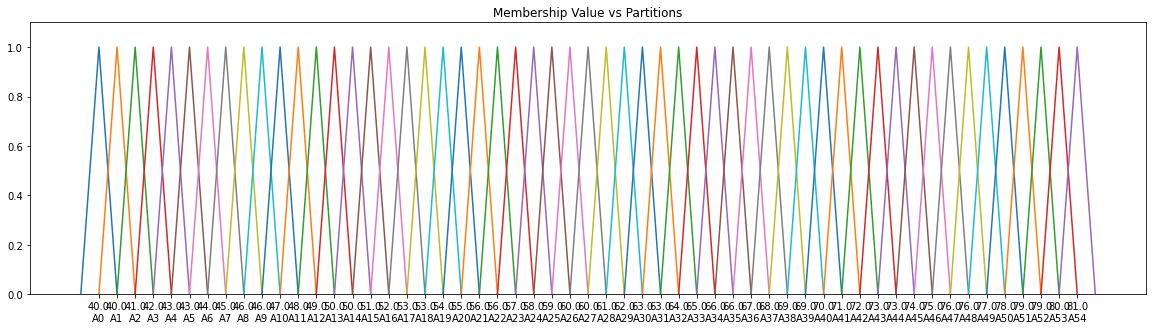

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])

partitioners = {}
partitioner = Grid.GridPartitioner(data=train, npart=55)
partitioners[dataset_name] = partitioner

pUtil.plot_sets(train, [partitioner.sets], titles=["Membership Value vs Partitions"], axis=ax)

## **Improved Weighted FTS usinf pyFTS**

In [ ]:
iwfts_model = ismailefendi.ImprovedWeightedFTS(partitioner=partitioners[dataset_name])
iwfts_model.name=dataset_name
iwfts_model.fit(train, save_model=True, file_path='iwfts_model'+dataset_name, order=6)

print(iwfts_model)

USD-INR-forex:
A6 -> A6(0.894),A7(0.106)
A7 -> A6(0.068),A7(0.864),A8(0.068)
A8 -> A7(0.092),A8(0.831),A9(0.077)
A9 -> A10(0.076),A8(0.083),A9(0.841)
A10 -> A10(0.703),A11(0.054),A9(0.243)
A11 -> A10(0.25),A11(0.5),A13(0.25)
A12 -> A12(0.789),A13(0.211)
A13 -> A12(0.148),A13(0.778),A14(0.074)
A14 -> A13(0.107),A14(0.786),A15(0.107)
A15 -> A14(0.061),A15(0.788),A16(0.152)
A16 -> A15(0.118),A16(0.765),A17(0.118)
A17 -> A16(0.064),A17(0.787),A18(0.149)
A18 -> A17(0.111),A18(0.741),A19(0.148)
A19 -> A18(0.056),A19(0.839),A20(0.105)
A20 -> A19(0.106),A20(0.755),A21(0.138)
A21 -> A19(0.021),A20(0.103),A21(0.835),A22(0.041)
A22 -> A21(0.167),A22(0.667),A23(0.167)
A23 -> A21(0.067),A23(0.8),A24(0.133)
A24 -> A23(0.167),A24(0.5),A25(0.333)
A25 -> A24(0.053),A25(0.789),A26(0.158)
A26 -> A25(0.04),A26(0.82),A27(0.1),A28(0.04)
A27 -> A26(0.052),A27(0.888),A28(0.06)
A28 -> A27(0.067),A28(0.833),A29(0.1)
A29 -> A28(0.059),A29(0.859),A30(0.076),A31(0.005)
A30 -> A29(0.112),A30(0.828),A31(0.06)
A31 ->

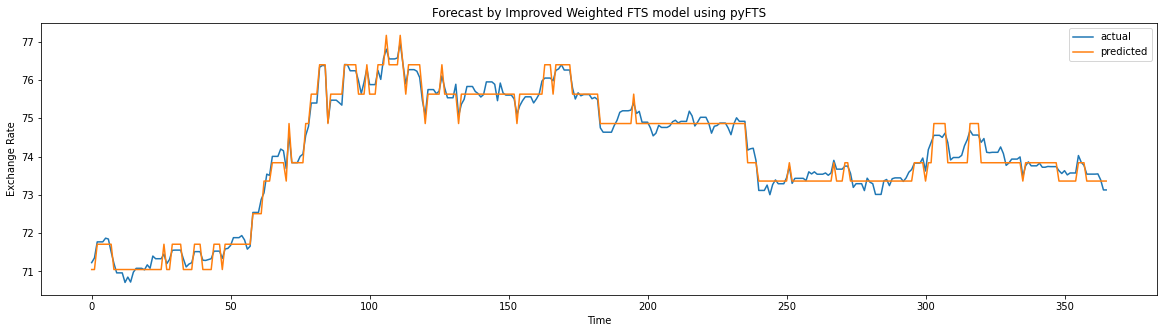

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])

ax.plot(test,label="actual")

iwfts_model = cUtil.load_obj('iwfts_model'+dataset_name)

forecasts = iwfts_model.predict(test)
    
ax.plot(forecasts,label="predicted")
    
ax.set_title("Forecast by Improved Weighted FTS model using pyFTS")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse1 = np.sqrt(skmet.mean_squared_error(test,forecasts))
print("RMSE for yearly prediction = " + str(rmse1))
mape1 = calculateMAPE(test,forecasts)
print("MAPE for yearly prediction = " + str(mape1))

RMSE for yearly prediction = 0.2015311555031352
MAPE for yearly prediction = 0.2233586197396348


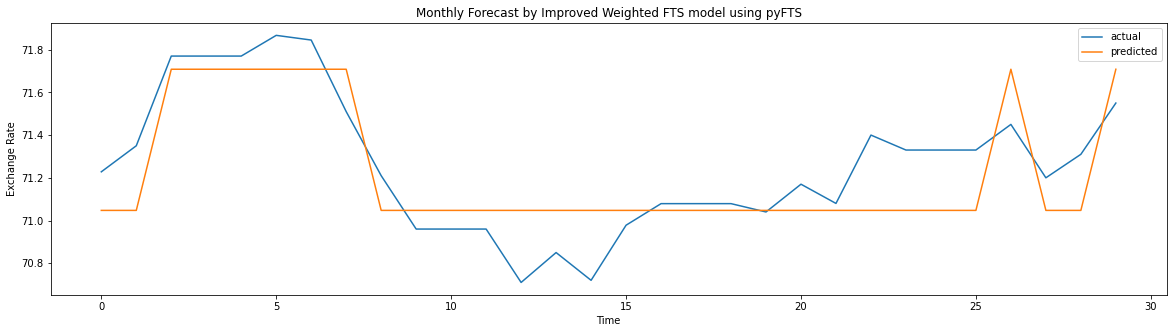

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])

ax.plot(test_month,label="actual")

iwfts_model = cUtil.load_obj('iwfts_model'+dataset_name)

forecasts_month = iwfts_model.predict(test_month)
    
ax.plot(forecasts_month,label="predicted")
    
ax.set_title("Monthly Forecast by Improved Weighted FTS model using pyFTS")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test_month,forecasts_month))
print("RMSE for monthly prediction = " + str(rmse))
mape = calculateMAPE(test_month,forecasts_month)
print("MAPE for monthly prediction = " + str(mape))

RMSE for monthly prediction = 0.19149236425531796
MAPE for monthly prediction = 0.22493226932100777


### **Forecasting for transformed ar differenced data**

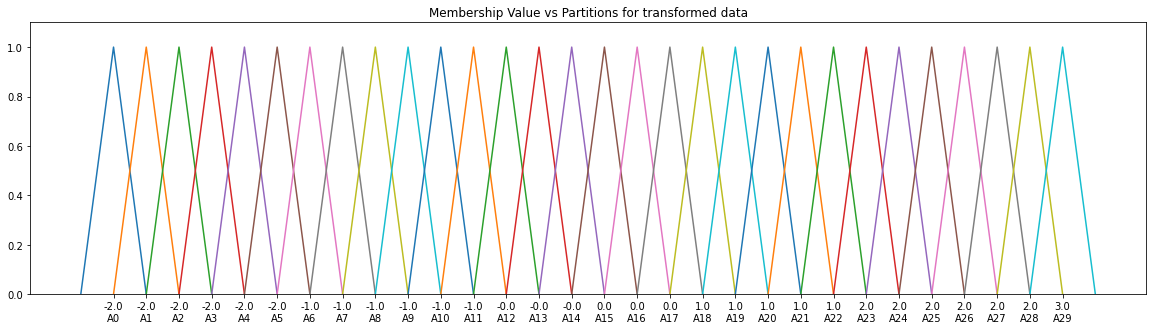

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])

partitioners_diff = {}
partitioner_diff = Grid.GridPartitioner(data=train, npart=30, transformation=tdiff)
partitioners_diff[dataset_name] = partitioner_diff

pUtil.plot_sets(train, [partitioner_diff.sets], titles=["Membership Value vs Partitions for transformed data"], axis=ax)

In [ ]:
iwfts_diff_model = ismailefendi.ImprovedWeightedFTS(partitioner=partitioners_diff[dataset_name])
iwfts_diff_model.name=dataset_name
iwfts_diff_model.append_transformation(tdiff)
iwfts_diff_model.fit(train, save_model=True, file_path='iwfts_diff_model'+dataset_name, order=6)

print(iwfts_diff_model)

USD-INR-forex:
A29 -> A1(1.0)
A1 -> A9(1.0)
A24 -> A11(0.5),A13(0.5)
A6 -> A11(0.5),A14(0.5)
A11 -> A10(0.02),A11(0.02),A12(0.078),A13(0.137),A14(0.392),A15(0.157),A16(0.137),A17(0.02),A8(0.039)
A9 -> A12(0.333),A13(0.167),A14(0.5)
A8 -> A10(0.2),A14(0.6),A16(0.2)
A12 -> A11(0.007),A12(0.092),A13(0.113),A14(0.451),A15(0.197),A16(0.092),A17(0.042),A9(0.007)
A19 -> A11(0.077),A12(0.077),A13(0.231),A14(0.308),A15(0.077),A17(0.231)
A17 -> A10(0.01),A11(0.048),A12(0.106),A13(0.135),A14(0.356),A15(0.173),A16(0.087),A17(0.058),A18(0.01),A21(0.01),A6(0.01)
A15 -> A10(0.005),A11(0.012),A12(0.042),A13(0.153),A14(0.479),A15(0.171),A16(0.106),A17(0.015),A18(0.008),A19(0.007),A8(0.002)
A7 -> A14(1.0)
A23 -> A14(1.0)
A13 -> A10(0.002),A11(0.02),A12(0.048),A13(0.14),A14(0.5),A15(0.172),A16(0.072),A17(0.035),A18(0.007),A20(0.002),A9(0.002)
A14 -> A10(0.002),A11(0.011),A12(0.026),A13(0.105),A14(0.59),A15(0.156),A16(0.065),A17(0.026),A18(0.008),A19(0.004),A20(0.001),A21(0.002),A23(0.001),A24(0.001),A5(0

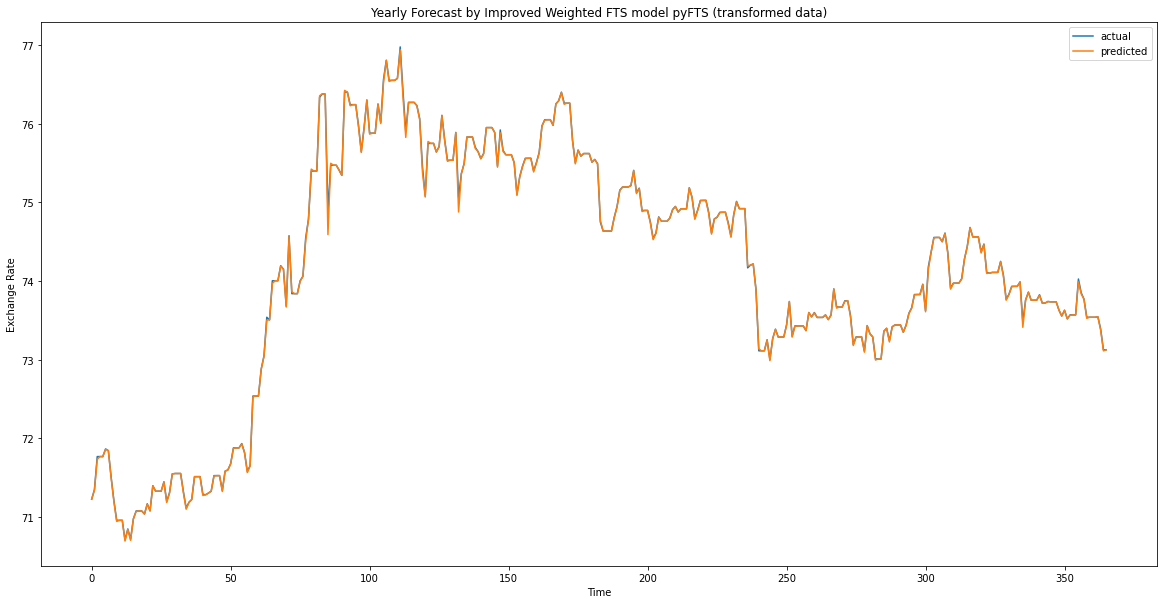

In [ ]:
iwfts_diff_model = cUtil.load_obj('iwfts_diff_model'+dataset_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])

ax.plot(test,label = "actual")
forecasts = iwfts_diff_model.predict(test) 
ax.plot(forecasts,label="predicted")
ax.set_title("Yearly Forecast by Improved Weighted FTS model pyFTS (transformed data)")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test,forecasts))
print("RMSE for yearly prediction = " + str(rmse))
mape = calculateMAPE(test,forecasts)
print("MAPE for yearly prediction = " + str(mape))

RMSE for yearly prediction = 0.021748288887362088
MAPE for yearly prediction = 0.00931629680230875


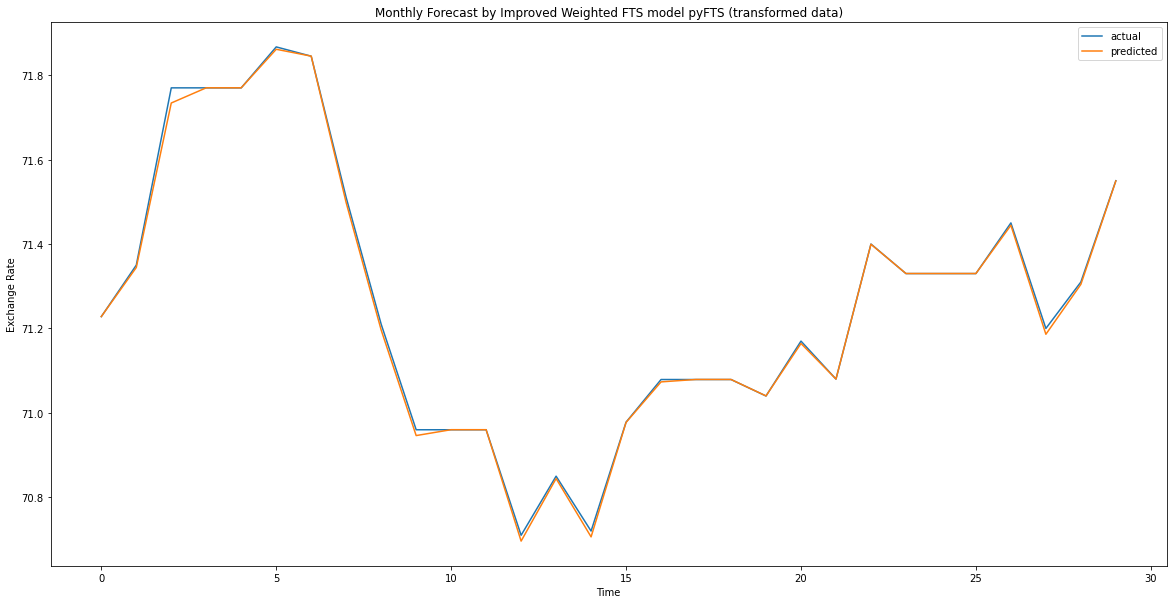

In [ ]:
iwfts_diff_model = cUtil.load_obj('iwfts_diff_model'+dataset_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])

ax.plot(test_month,label = "actual")
forecasts_month = iwfts_diff_model.predict(test_month) 
ax.plot(forecasts_month,label="predicted")
ax.set_title("Monthly Forecast by Improved Weighted FTS model pyFTS (transformed data)")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
rmse = math.sqrt(skmet.mean_squared_error(test_month,forecasts_month))
print("RMSE for monthly prediction = " + str(rmse))
mape = calculateMAPE(test_month,forecasts_month)
print("MAPE for monthly prediction = " + str(mape))

RMSE for monthly prediction = 0.009326604504440512
MAPE for monthly prediction = 0.0074742373481182295


## **Interval Fuzzy Time Series**

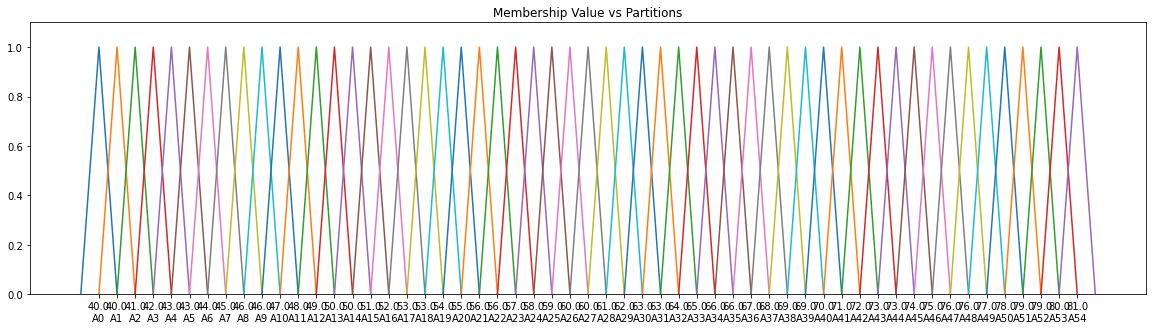

In [ ]:
from pyFTS.partitioners import Grid, Util as pUtil

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])

fuzzy_sets = Grid.GridPartitioner(data=train, npart=55)
fuzzy_sets2 = Grid.GridPartitioner(data=train, npart=30, transformation=tdiff)

pUtil.plot_sets(train, [fuzzy_sets.sets], titles=["Membership Value vs Partitions"], axis=ax)

In [ ]:
ifts_model = ifts.IntervalFTS(partitioner=fuzzy_sets)
ifts_model.fit(train, order=6)

print(ifts_model)

Interval FTS:
A5 -> A5,A6,A7
A6 -> A5,A6,A7,A8
A7 -> A5,A6,A7,A8,A9
A8 -> A10,A6,A7,A8,A9
A9 -> A10,A11,A7,A8,A9
A10 -> A10,A11,A12,A8,A9
A11 -> A10,A11,A12,A13,A14,A9
A12 -> A11,A12,A13,A14
A13 -> A11,A12,A13,A14,A15
A14 -> A12,A13,A14,A15,A16
A15 -> A13,A14,A15,A16,A17
A16 -> A14,A15,A16,A17,A18
A17 -> A15,A16,A17,A18,A19
A18 -> A16,A17,A18,A19,A20
A19 -> A16,A17,A18,A19,A20,A21
A20 -> A18,A19,A20,A21,A22
A21 -> A19,A20,A21,A22,A23
A22 -> A19,A20,A21,A22,A23,A24,A25
A23 -> A20,A21,A22,A23,A24,A25
A24 -> A23,A24,A25,A26,A27
A25 -> A23,A24,A25,A26,A27
A26 -> A24,A25,A26,A27,A28
A27 -> A25,A26,A27,A28,A29
A28 -> A26,A27,A28,A29,A30,A31
A29 -> A27,A28,A29,A30,A31
A30 -> A28,A29,A30,A31,A32,A33
A31 -> A28,A29,A30,A31,A32,A33
A32 -> A28,A29,A30,A31,A32,A33,A34,A35
A33 -> A30,A31,A32,A33,A34,A35
A34 -> A31,A32,A33,A34,A35,A36,A37,A38,A39
A36 -> A34,A35,A36,A37,A38
A35 -> A33,A34,A35,A36,A37,A38,A39
A37 -> A35,A36,A37,A38,A39
A38 -> A35,A36,A37,A38,A39,A40
A39 -> A35,A36,A37,A38,A39,A40,A41


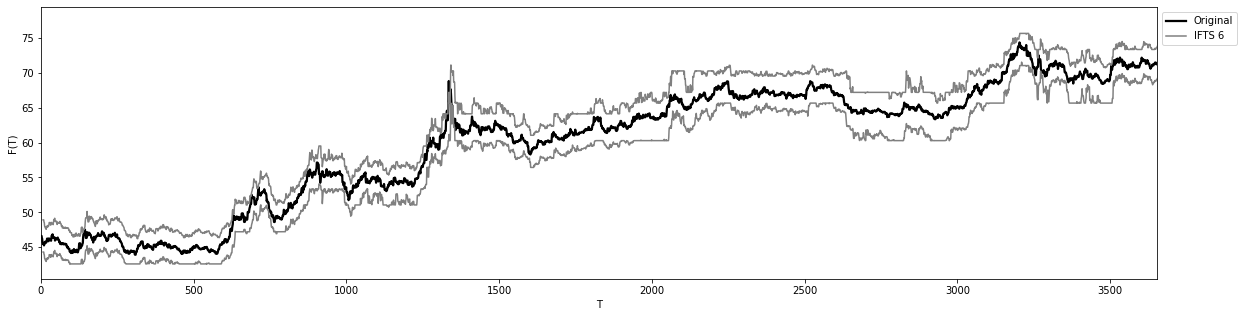

In [ ]:
bchmk.plot_compared_series(train, [ifts_model], bchmk.colors,typeonlegend=False,points=False, intervals=True)

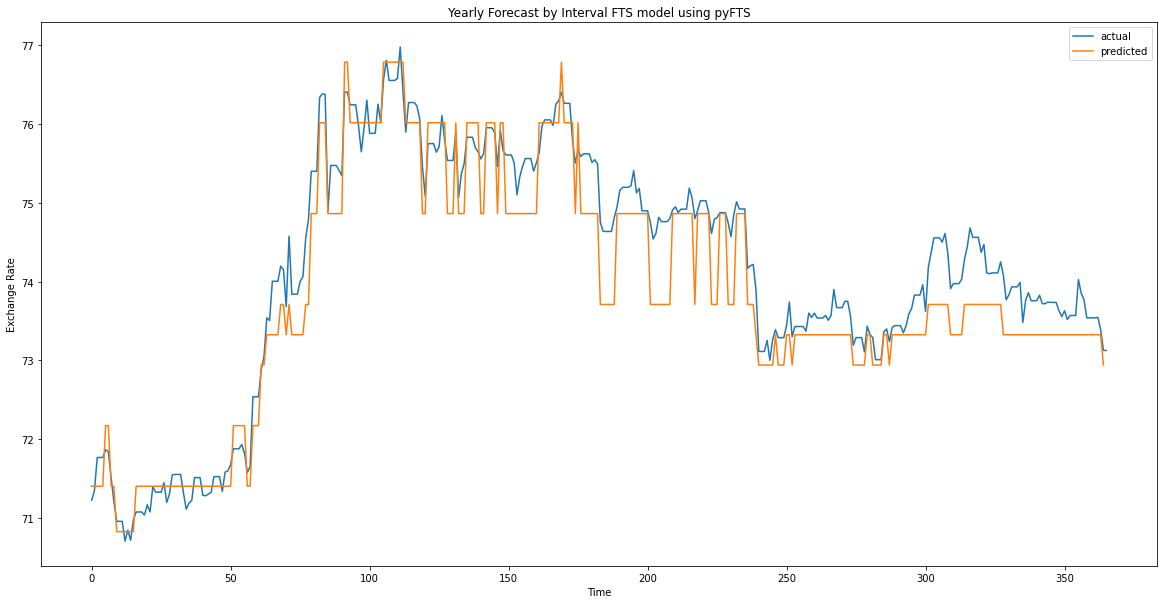

In [ ]:
ifts_forecast = ifts_model.predict(test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])

ax.plot(test,label="actual")
ax.plot(ifts_forecast,label="predicted")
ax.set_title("Yearly Forecast by Interval FTS model using pyFTS")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
if len(ifts_forecast) < len(test):
  ifts_forecast.append(ifts_forecast[-1])
rmse1 = np.sqrt(skmet.mean_squared_error(test,ifts_forecast))
print("RMSE for yearly prediction = " + str(rmse1))
mape1 = calculateMAPE(test,ifts_forecast)
print("MAPE for yearly prediction = " + str(mape1))

RMSE for yearly prediction = 0.4564030581431561
MAPE for yearly prediction = 0.4904826080910061


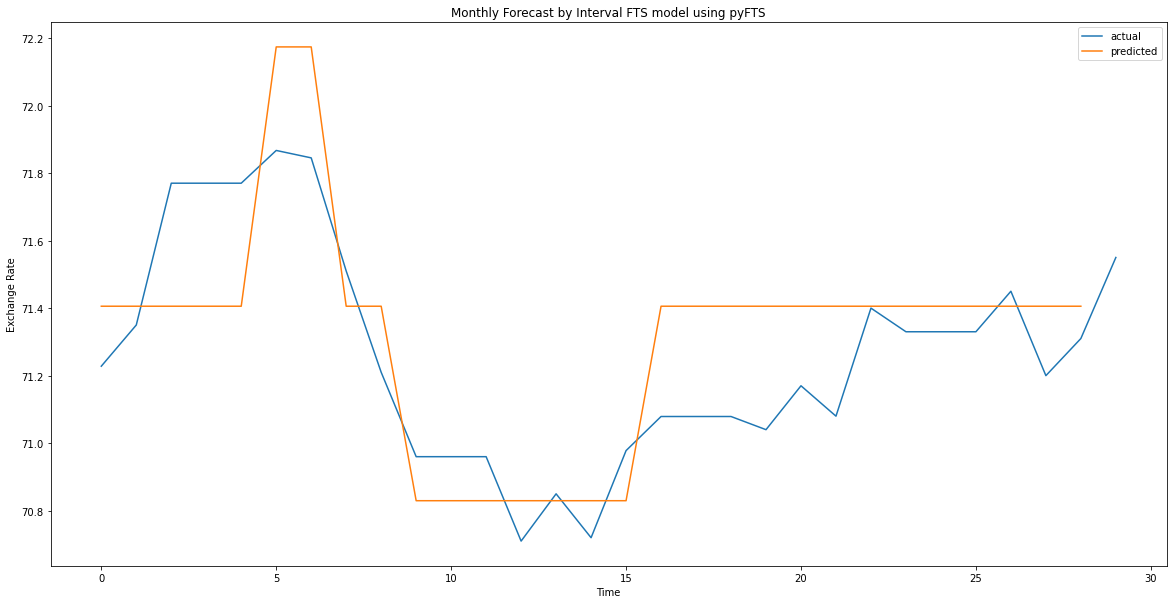

In [ ]:
ifts_forecast_month = ifts_model.predict(test_month)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])

ax.plot(test_month,label="actual")
ax.plot(ifts_forecast_month,label="predicted")
ax.set_title("Monthly Forecast by Interval FTS model using pyFTS")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
if len(ifts_forecast_month) < len(test_month):
  ifts_forecast_month.append(ifts_forecast_month[-1])
rmse1 = np.sqrt(skmet.mean_squared_error(test_month,ifts_forecast_month))
print("RMSE for monthly prediction = " + str(rmse1))
mape1 = calculateMAPE(test_month,ifts_forecast_month)
print("MAPE for monthly prediction = " + str(mape1))

RMSE for monthly prediction = 0.22290988667543696
MAPE for monthly prediction = 0.26545827086002133


### **Forecasting for transformed or differenced data**

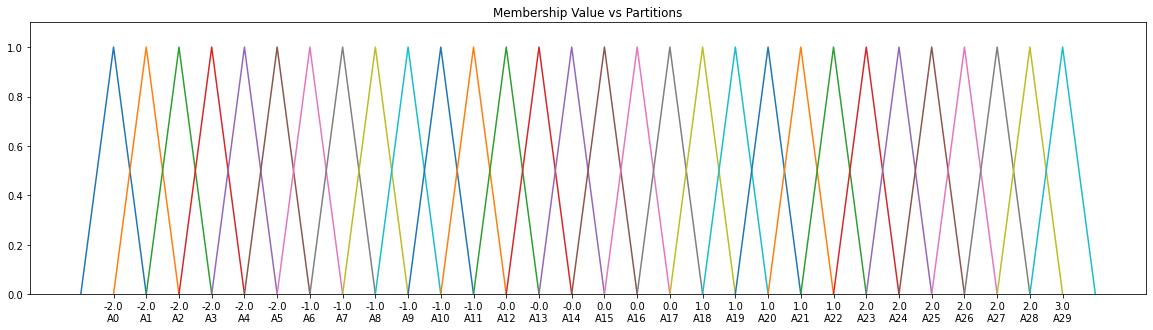

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,5])

pUtil.plot_sets(train, [fuzzy_sets2.sets], titles=["Membership Value vs Partitions"], axis=ax)

In [ ]:
ifts_diff_model = ifts.IntervalFTS(partitioner=fuzzy_sets2)
ifts_diff_model.append_transformation(tdiff)
ifts_diff_model.fit(train, save_model=True, file_path='ifts_diff_model'+dataset_name, order=1)

print(ifts_diff_model)

Interval FTS:
A28 -> A1,A2
A29 -> A1,A2
A1 -> A10,A9
A2 -> A10,A9
A24 -> A10,A11,A12,A13
A9 -> A10,A11,A12,A13,A14,A15,A16,A9
A6 -> A10,A11,A14,A15
A23 -> A10,A11,A12,A13,A14,A15
A12 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A8,A9
A11 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A8,A9
A8 -> A10,A11,A12,A13,A14,A15,A16,A17,A9
A10 -> A11,A12,A13,A14,A15,A16,A17,A18,A8,A9
A13 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A6,A7,A8,A9
A22 -> A12,A13,A14,A15
A7 -> A10,A11,A14,A15,A16,A17
A14 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A4,A5,A6,A7,A8,A9
A15 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A4,A5,A6,A7,A8,A9
A17 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A21,A22,A6,A7
A19 -> A11,A12,A13,A14,A15,A16,A17,A18
A16 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A21,A22,A23,A24,A6,A7,A8,A9
A18 -> A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A21,A22
A4 -> A16,A17
A5 -> A16,A17
A21 -> A11,A12,A13,A14,A15,A16,A25,A26
A20 -> A11,A12,A13,A14,A15,A16,A17,A25,A26
A25 -> 

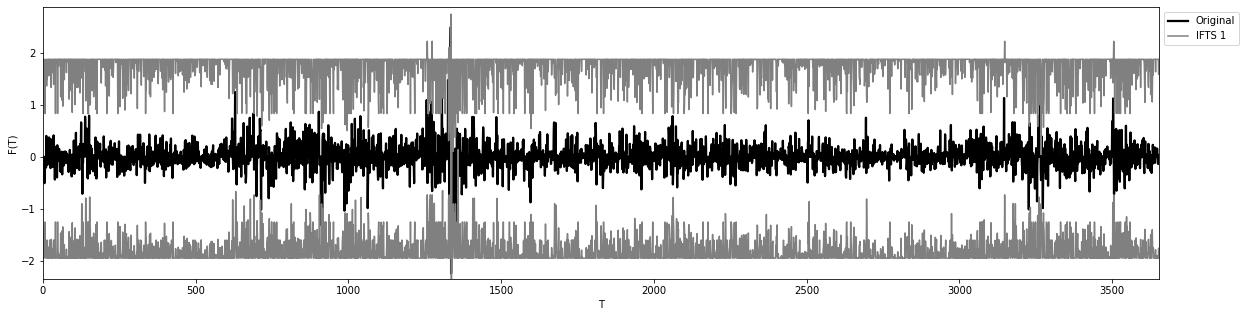

In [ ]:
bchmk.plot_compared_series(train_diff, [ifts_diff_model], bchmk.colors,typeonlegend=False,points=False, intervals=True)

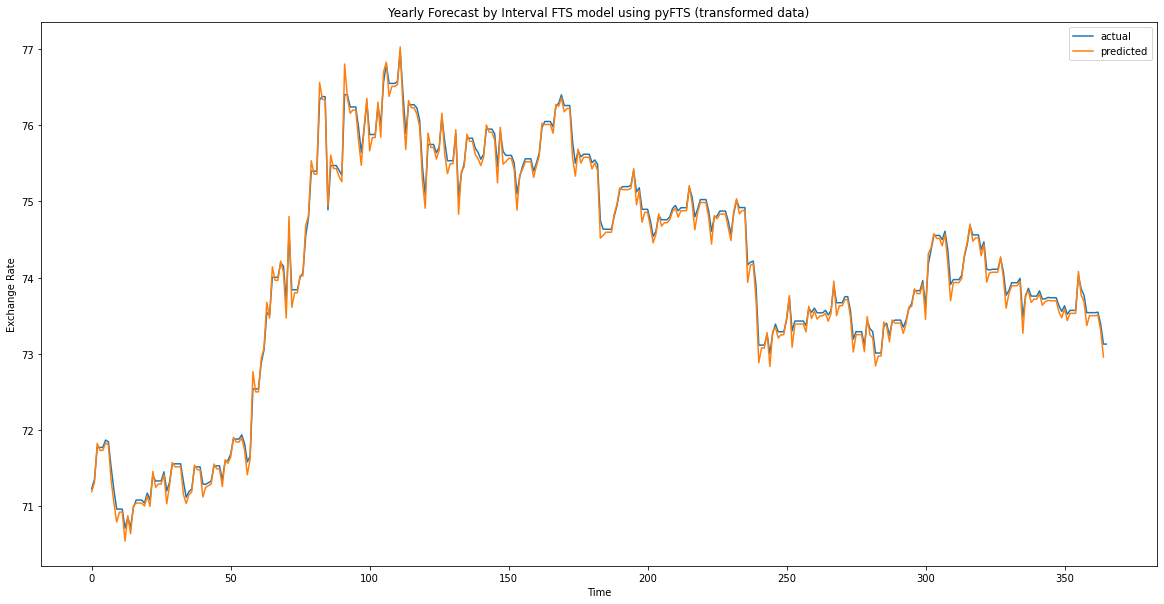

In [ ]:
ifts_diff_model = cUtil.load_obj('ifts_diff_model'+dataset_name)

ifts_diff_forecasts = ifts_diff_model.predict(test)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])

ax.plot(test,label = "actual")
ax.plot(ifts_diff_forecasts,label="predicted") 
ax.set_title("Yearly Forecast by Interval FTS model using pyFTS (transformed data)")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
if len(ifts_diff_forecasts) < len(test):
  ifts_diff_forecasts.append(ifts_diff_forecasts[-1])
rmse1 = np.sqrt(skmet.mean_squared_error(test,ifts_diff_forecasts))
print("RMSE for yearly prediction = " + str(rmse1))
mape1 = calculateMAPE(test,ifts_diff_forecasts)
print("MAPE for yearly prediction = " + str(mape1))

RMSE for yearly prediction = 0.0894071996451081
MAPE for yearly prediction = 0.09338792860940123


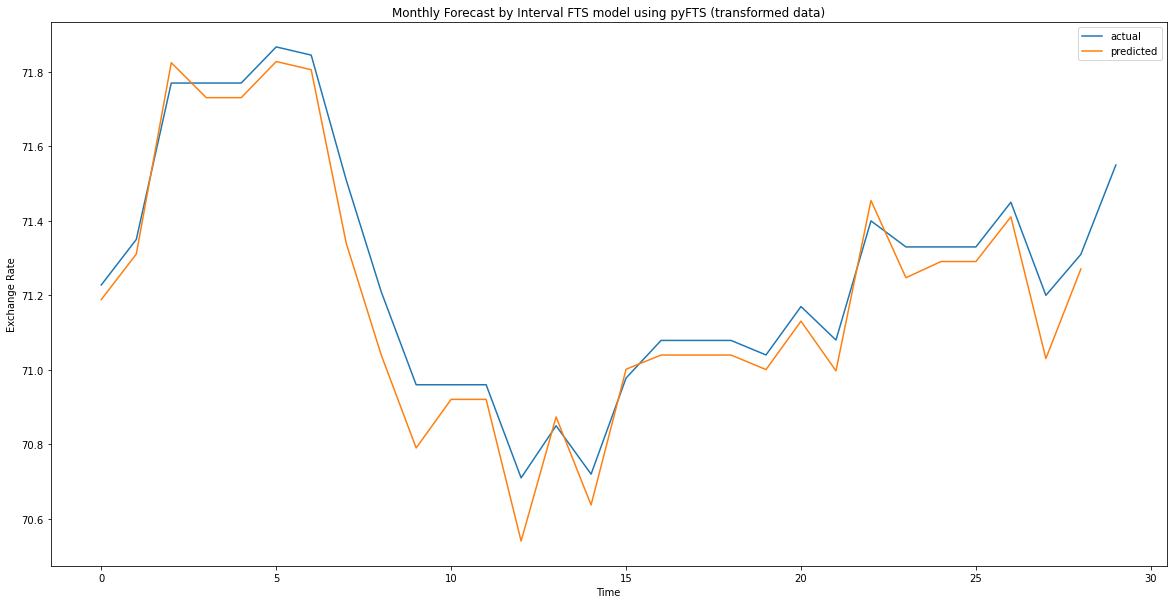

In [ ]:
ifts_diff_model = cUtil.load_obj('ifts_diff_model'+dataset_name)

ifts_diff_forecasts_month = ifts_diff_model.predict(test_month)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])

ax.plot(test_month,label = "actual")
ax.plot(ifts_diff_forecasts_month,label="predicted") 
ax.set_title("Monthly Forecast by Interval FTS model using pyFTS (transformed data)")
ax.set_xlabel("Time")
ax.set_ylabel("Exchange Rate")
ax.legend(loc='upper right')

In [ ]:
if len(ifts_diff_forecasts_month) < len(test_month):
  ifts_diff_forecasts_month.append(ifts_diff_forecasts_month[-1])
rmse1 = np.sqrt(skmet.mean_squared_error(test_month,ifts_diff_forecasts_month))
print("RMSE for monthly prediction = " + str(rmse1))
mape1 = calculateMAPE(test_month,ifts_diff_forecasts_month)
print("MAPE for monthly prediction = " + str(mape1))

RMSE for monthly prediction = 0.09587944629667275
MAPE for monthly prediction = 0.10290613558225085
